This notebook contains the modelling steps taking to train the LSTM on our oil and gas dataset. Disclaimer: Note that to run this notebook,it is highly recommend that you use a machine with a GPU, as training can take at least half a day on a GPU alone.

# Step 1: Imports

In [13]:
import os
import re
from datetime import datetime

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.initializers import GlorotUniform, Constant
from keras.regularizers import L2
from scikeras.wrappers import KerasRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

In [4]:
# Check GPU
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# Configure TensorFlow to use the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Num GPUs Available:  0


# Step 2: Load the training and testing dataset

In [7]:
# Directory to save the model weights
save_dir = "../../data/results/lstm"
os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist

In [8]:
# Replace the filenames with the names of your uploaded files
train_data = pd.read_csv('../../data/processed-data/train_data.csv')
test_data = pd.read_csv('../../data/processed-data/test_data.csv')

# Preview the first few rows to ensure the data is loaded correctly
print("Training Data:")
print(train_data.head(), "\n")

print("Testing Data:")
print(test_data.head(), "\n")

# Check for missing values
print("Training Data - Missing Values:\n", train_data.isnull().sum())
print("Testing Data - Missing Values:\n", test_data.isnull().sum())

combined_df = pd.concat([train_data, test_data], axis=0)

Training Data:
  symbol      open      high       low     close     volume        date  \
0     BP  56.71001  58.38800  56.60001  58.11000  3795646.0  2009-11-27   
1     BP  57.03000  57.59000  56.71001  57.17999  5784098.0  2009-11-30   
2     BP  58.32001  58.78999  58.22000  58.58000  3918975.0  2009-12-01   
3     BP  58.53999  59.00000  58.37000  58.64000  3950568.0  2009-12-02   
4     BP  58.17000  58.48000  57.61000  57.62000  5372031.0  2009-12-03   

   daily_variation  daily_return   7day_SMA  ...  30day_WMA   7day_EMA  \
0          1.78799     -0.018744  58.627144  ...  58.309269  58.601345   
1          0.87999     -0.016004  58.332856  ...  58.272214  58.246006   
2          0.56999      0.024484  58.325713  ...  58.320817  58.329505   
3          0.63000      0.001024  58.441427  ...  58.368602  58.407128   
4          0.87000     -0.017394  58.295713  ...  58.345290  58.210346   

   30day_EMA  momentum      MACD  MACD_signal  MACD_hist        RSI  \
0  57.506422  -1.3

# Step 3: Find the number of lags

In [9]:
def plot_pacf_for_all_stocks(data, target_col='close', lags=50):
    """
    Plots the PACF for each stock symbol present in the dataset in a 2x3 subplot layout.

    Parameters:
    - data (pd.DataFrame): The input dataset containing stock data.
    - target_col (str): The target column to analyze (e.g., 'close').
    - lags (int): Number of lags to include in the PACF plot.
    """
    # Get the list of unique stock symbols
    symbols = data['symbol'].unique()

    # Create a 2x3 subplot layout
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    fig.tight_layout(pad=4)  # Adjusts spacing between plots

    for i, symbol in enumerate(symbols[:6]):  # Limit to 6 symbols for a 2x3 layout
        stock_data = data[data['symbol'] == symbol][target_col]

        ar_coeff = np.zeros(104)
        ar_coeff[0] = 1
        ar_coeff[103] = 0.8
        ma_coeff = np.array([1])
        ar_process = ArmaProcess(ar_coeff, ma_coeff)
        stock_data = ar_process.generate_sample(nsample=1000)

        # Plot PACF on the appropriate subplot
        ax = axes[i // 3, i % 3]  # Calculate row and column indices
        plot_pacf(stock_data, lags=lags, ax=ax)
        ax.set_title(f"PACF Plot for {symbol} - {target_col}")

    # Hide any unused subplots
    for j in range(len(symbols), 6):
        fig.delaxes(axes[j // 3, j % 3])

    plt.show()

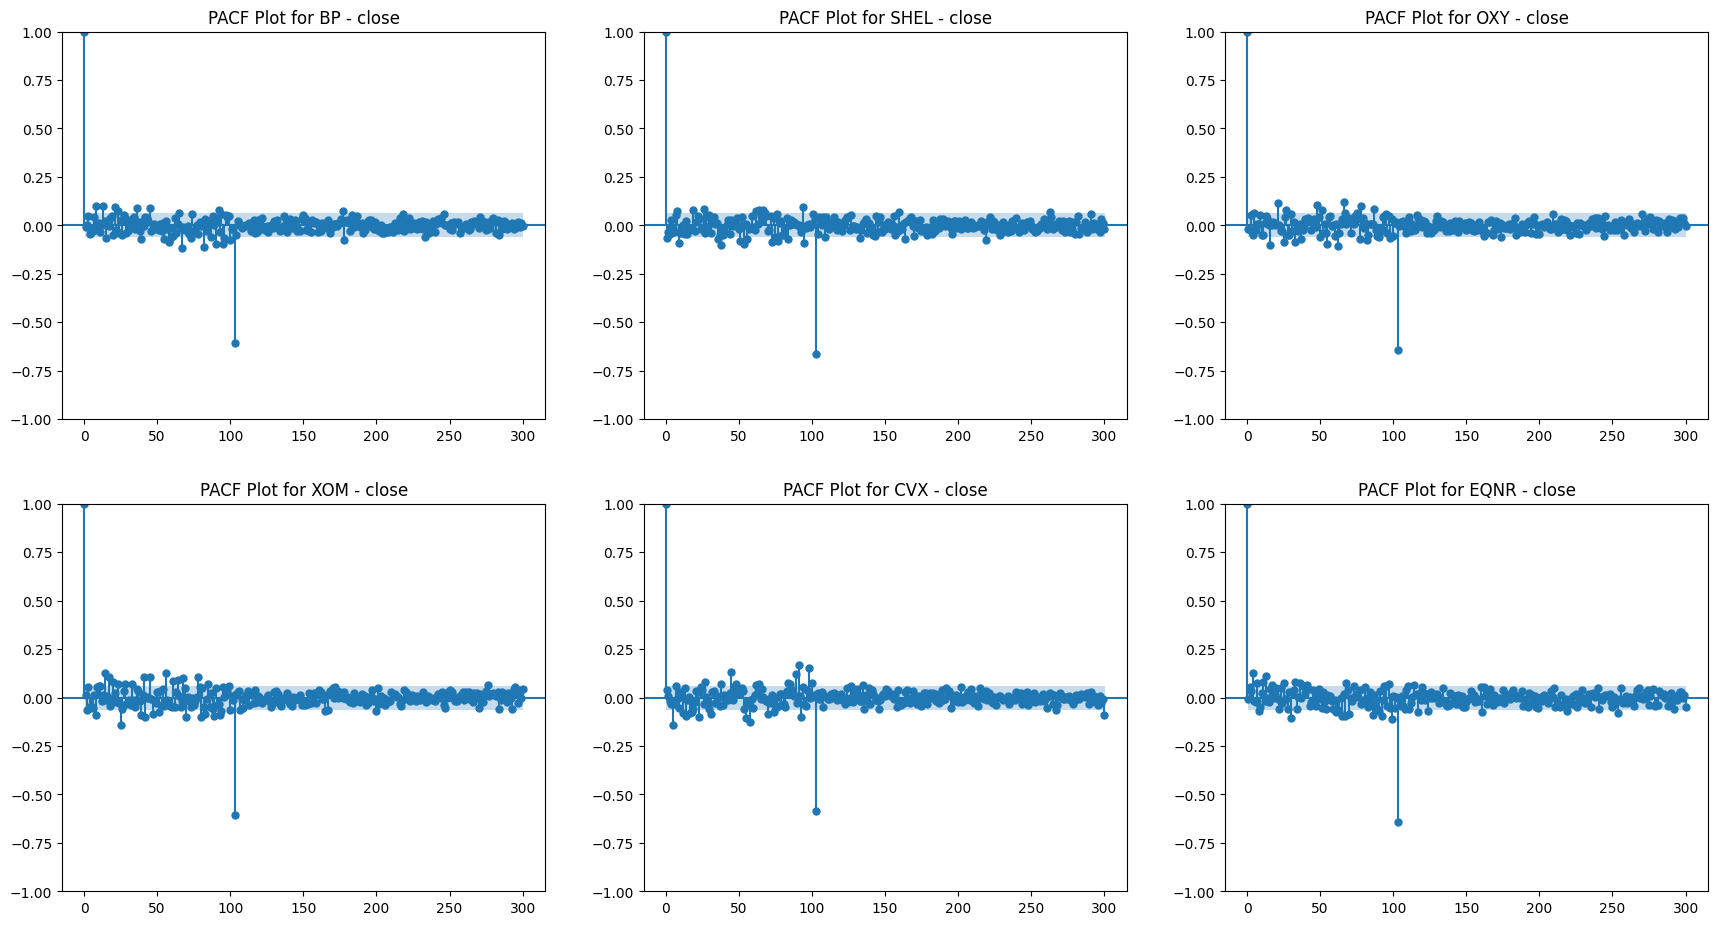

In [14]:
# Call the function with your loaded training dataset
plot_pacf_for_all_stocks(train_data, target_col='close', lags=300)

# Step 4:Pivot wider and add lag

In [15]:
def prepare_wide_format(data, target_stocks, feature_stocks, selected_columns, lag=50):
    """
    Converts the dataset to wide format with lagged features for LSTM input.

    Parameters:
    - data (pd.DataFrame): Input dataset in long format.
    - target_stocks (list): List of stock symbols to predict.
    - feature_stocks (list): List of extra stocks used as explanatory variables.
    - lag (int): Number of days to use for lagged features.

    Returns:
    - target_df (pd.DataFrame): DataFrame in wide format for target stocks.
    - feature_df (pd.DataFrame): DataFrame in wide format for feature stocks.
    """
    # Filter data based on selected columns
    data = data[selected_columns]

    # # 1. Ensure 'datetime' is in datetime format
    # data['datetime'] = pd.to_datetime(data['datetime'])

    # 2. Convert 'datetime' to just date
    data['date'] = pd.to_datetime(data['date']).dt.date

    # # 3. Drop the 'datetime' column
    # data = data.drop(columns=['datetime'], inplace=False)

    # 4. Filter relevant data
    target_data = data[data['symbol'].isin(target_stocks)]
    feature_data = data[data['symbol'].isin(feature_stocks)]

    # 5. Pivot to wide format by symbol and date
    target_df = target_data.pivot(index='date', columns='symbol')
    feature_df = feature_data.pivot(index='date', columns='symbol')

    # 6. Flatten the multi-level index
    target_df.columns = [f"{col[1]}_{col[0]}" for col in target_df.columns]
    feature_df.columns = [f"{col[1]}_{col[0]}" for col in feature_df.columns]

    # 7. Align DataFrames to have the same date index
    if feature_stocks:
        common_index = target_df.index.intersection(feature_df.index)
        target_df = target_df.loc[common_index]
        feature_df = feature_df.loc[common_index]
        # 8. Create lagged features for both target and feature stocks
        def create_lagged_features(df, lag):
            """
            Creates lagged versions of all features in the DataFrame.
            """
            lagged_df = pd.concat(
                [df.shift(i).add_suffix(f"_lag_{i}") for i in range(1, lag + 1)], axis=1
            )
            return lagged_df

        # Apply lagging
        X_targets = create_lagged_features(target_df, lag).dropna()
        X_features = create_lagged_features(feature_df, lag).dropna()

        # 9. Combine target stock lags and feature stock lags
        X = pd.concat([X_targets, X_features], axis=1)

        # 10. Align DataFrames to have the same date index
        common_index = X_targets.index.intersection(target_df.index)
        target_df = target_df.loc[common_index]
        feature_df = feature_df.loc[common_index]

        # 10. Extract the target variable (only 'close' prices of target stocks)
        y = target_df[[f"{stock}_close" for stock in target_stocks]].dropna()

        # Ensure X and y have matching indexes after the shift
        X, y = X.loc[y.index], y

        return X, y
    else:
        # 8. Create lagged features for both target and feature stocks
        def create_lagged_features(df, lag):
            """
            Creates lagged versions of all features in the DataFrame.
            """
            lagged_df = pd.concat(
                [df.shift(i).add_suffix(f"_lag_{i}") for i in range(1, lag + 1)], axis=1
            )
            return lagged_df

        # Apply lagging
        X = create_lagged_features(target_df, lag).dropna()

        # 10. Extract the target variable (only 'close' prices of target stocks)
        common_index = X.index.intersection(target_df.index)
        target_df = target_df.loc[common_index]
        y = target_df[[f"{stock}_close" for stock in target_stocks]].dropna()

        # Ensure X and y have matching indexes after the shift
        X, y = X.loc[y.index], y

        return X, y

In [16]:
# Function to extract the lag number from column names
def extract_lag_number(col):
    match = re.search(r'_lag_(\d+)', col)
    return int(match.group(1)) if match else float('inf')

# Step 5: Create model architecture

In [17]:
class ReshapeForLSTM(BaseEstimator, TransformerMixin):
    def __init__(self, time_steps=100):
        self.time_steps = time_steps

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Handle both DataFrame and NumPy array
        if isinstance(X, pd.DataFrame):
            X = X.values  # Convert DataFrame to NumPy array

        # Reshape to (samples, time_steps, features)
        n_samples = X.shape[0]
        n_features = X.shape[1] // self.time_steps
        return X.reshape((n_samples, self.time_steps, n_features))

In [18]:
def create_lstm_model(layer_1_units, layer_2_units, dense_activation, input_shape, optimizer, loss):
    model = Sequential()

    # First LSTM layer with initializers
    model.add(LSTM(layer_1_units,
                   activation='tanh',
                   return_sequences=True,
                   input_shape=input_shape,
                   kernel_initializer=GlorotUniform(),
                   bias_initializer=Constant(0.1)))

    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    # Second LSTM layer with initializers
    model.add(LSTM(layer_2_units,
                   activation='tanh',
                   kernel_initializer=GlorotUniform(),
                   bias_initializer=Constant(0.1)))

    model.add(Dropout(0.2))

    # Output layer with initializers
    model.add(Dense(1,
                    activation = dense_activation,
                    kernel_initializer=GlorotUniform(),
                    bias_initializer=Constant(0.1),
                    kernel_regularizer=L2(0.01)))  # L2 regularization for the output layer

    model.compile(optimizer=optimizer, loss=loss)

    return model

# Step 6: Writing the code for predictions

In [10]:
def predict_stock_prices(test_X, scaler, y_scaler, lag, model):
    """
    Predicts stock prices using a pre-trained model with scaled inputs and lagged features.

    Parameters:
    -----------
    test_X : np.ndarray
        The test dataset (features) to predict on.
    scaler : object
        Fitted scaler used to normalize the input features.
    y_scaler : object
        Fitted scaler used to inverse transform the predicted values.
    lag : int
        The number of lagged time steps used in the model.
    model : object
        Trained machine learning model for predictions.

    Returns:
    --------
    np.ndarray
        The inverse-transformed predictions.
    """
    # Step 1: Scale the test features
    X_test_scaled = scaler.transform(test_X)

    # Step 2: Reshape the data to match the input shape expected by the model
    n_features = X_test_scaled.shape[1] // lag
    X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], lag, n_features))

    # Step 3: Predict using the model
    y_pred = model.predict(X_test_reshaped)

    # Step 4: Inverse transform the predictions to get original scale
    y_pred_inverse = y_scaler.inverse_transform(y_pred)

    return y_pred_inverse

In [11]:
def plot_predictions_vs_actuals(y_pred, test_y, target_stocks):
    """
    Plots predicted vs actual stock prices for multiple stocks.

    Parameters:
    -----------
    y_pred : np.ndarray or pd.DataFrame
        Predicted stock prices.
    test_y : pd.DataFrame or np.ndarray
        Actual stock prices with date index.
    target_stocks : list of str
        List of target stock names corresponding to each prediction.
    num_samples : int, optional
        Number of samples to plot (default is 879).
    """
    # Convert to NumPy arrays if they are DataFrames
    y_pred = y_pred.to_numpy() if hasattr(y_pred, 'to_numpy') else y_pred
    y_test = test_y.to_numpy() if hasattr(test_y, 'to_numpy') else test_y

    # Plotting predictions vs actuals for each stock
    plt.figure(figsize=(18, 6))

    num_samples = len(y_pred)

    for stock in range(1):
        plt.plot(
            test_y.index[:num_samples],
            y_pred[:num_samples, stock],
            label='Predicted', linestyle='-', color='blue'
        )
        plt.plot(
            test_y.index[:num_samples],
            y_test[:num_samples, stock],
            label='Actual', linestyle='-', color='orange'
        )
        plt.title(target_stocks[stock])
        plt.xlabel('Sample')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()
    return y_test, y_pred

In [21]:
def get_naive_prediction(combined_y, y_actual, lag=1):
    """
    Generates naive predictions by shifting the actual values by a specified lag
    and aligns them with y_actual based on matching dates.

    Parameters:
    - combined_y (pd.DataFrame or pd.Series): Full time series with all actual values, indexed by date.
    - y_actual (pd.DataFrame or pd.Series): Subset of actual values to align the naive predictions with, indexed by date.
    - lag (int): The lag to use for the naive forecast (default is 100).

    Returns:
    - y_naive (np.ndarray): Naive forecast values aligned with the dates in y_actual.
    """
    # Ensure combined_y is a 1D Series
    if isinstance(combined_y, pd.DataFrame):
        combined_y = combined_y.squeeze()  # Convert (n, 1) to (n,)

    # Ensure y_actual is a Series for alignment
    if isinstance(y_actual, pd.DataFrame):
        y_actual = y_actual.squeeze()

    # Generate naive predictions by shifting the series by the specified lag
    y_naive = combined_y.shift(lag)

    # Replace NaN values at the start of the series with the first valid value
    y_naive.iloc[:lag] = combined_y.iloc[0]

    # Align naive predictions with the dates in y_actual
    y_naive_aligned = y_naive.loc[y_actual.index]

    return y_naive_aligned.values

# Step 7: Set up training loop via Gridsearch CV

In [19]:
param_grid = {
    'model__layer_1_units': [250, 100],       # Number of units in the LSTM layer
    'model__layer_2_units': [100, 50],
    'model__optimizer': ['adam'], # Optimizers to try
    'model__loss': ['mean_squared_error', 'mean_absolute_error'],
    'model__dense_activation': [None, 'tanh', 'sigmoid', 'softplus'],
    'batch_size': [32], # Batch sizes
    'epochs': [100, 150] # Number of epochs
}

target_stocks = ['BP', 'CVX', 'EQNR', 'OXY', 'SHEL','XOM']  # 6 stocks that we are predicting
feature_stocks = ['NYMEX:CL1!', 'NYMEX:NG1!']  # Additional stocks as features

selected_columns = ["date", "symbol", "close"]
lag = [100, 100, 100, 100, 100, 100]

Shape of X (features): (3643, 100)
Shape of y (target): (3643, 1)
Fitting 3 folds for each of 64 candidates, totalling 192 fits


/tmp/ipykernel_2038/612497795.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date']).dt.date
2024-10-27 05:29:34.718984: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 05:29:34.747551: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 05:29:34.772205: I ten

Epoch 1/100
Epoch 1/100


2024-10-27 05:29:40.768087: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-10-27 05:29:40.792630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-10-27 05:29:40.965825: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f477a6f0af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-27 05:29:40.965826: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2fd25903a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-27 05:29:40.965859: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-10-27 05:29:40.965863: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-10-27 05:29:41.012574: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] dis

44/44 - 6s - loss: 0.1717 - val_loss: 2.2778 - 6s/epoch - 144ms/step
Epoch 2/100
44/44 - 6s - loss: 0.1713 - val_loss: 4.8281 - 6s/epoch - 147ms/step
Epoch 2/100
44/44 - 1s - loss: 0.0963 - val_loss: 2.6748 - 933ms/epoch - 21ms/step
Epoch 3/100
44/44 - 1s - loss: 0.0889 - val_loss: 3.9969 - 933ms/epoch - 21ms/step
Epoch 3/100
44/44 - 1s - loss: 0.0839 - val_loss: 2.5669 - 928ms/epoch - 21ms/step
Epoch 4/100
44/44 - 1s - loss: 0.0717 - val_loss: 3.8328 - 936ms/epoch - 21ms/step
Epoch 4/100
44/44 - 1s - loss: 0.0641 - val_loss: 2.9300 - 935ms/epoch - 21ms/step
Epoch 5/100
44/44 - 1s - loss: 0.0585 - val_loss: 2.7430 - 944ms/epoch - 21ms/step
Epoch 5/100
44/44 - 1s - loss: 0.0548 - val_loss: 2.6505 - 916ms/epoch - 21ms/step
Epoch 6/100
44/44 - 1s - loss: 0.0596 - val_loss: 3.2787 - 938ms/epoch - 21ms/step
Epoch 6/100
44/44 - 1s - loss: 0.0513 - val_loss: 2.3029 - 925ms/epoch - 21ms/step
Epoch 7/100
44/44 - 1s - loss: 0.0508 - val_loss: 2.7919 - 927ms/epoch - 21ms/step
Epoch 7/100
44/44 - 

/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.lo

44/44 - 0s - loss: 0.0699 - val_loss: 0.0148 - 490ms/epoch - 11ms/step
Epoch 16/100
44/44 - 0s - loss: 0.0689 - val_loss: 0.0134 - 480ms/epoch - 11ms/step
Epoch 17/100


/home/ubuntu/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


44/44 - 1s - loss: 0.0694 - val_loss: 0.0175 - 502ms/epoch - 11ms/step
Epoch 18/100
44/44 - 1s - loss: 0.0670 - val_loss: 0.0158 - 540ms/epoch - 12ms/step
Epoch 19/100


2024-10-27 05:53:33.949186: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 05:53:34.009852: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


44/44 - 1s - loss: 0.0682 - val_loss: 0.0174 - 506ms/epoch - 11ms/step
Epoch 20/100


2024-10-27 05:53:34.851654: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


44/44 - 1s - loss: 0.0685 - val_loss: 0.0120 - 506ms/epoch - 11ms/step
Epoch 21/100
44/44 - 1s - loss: 0.0671 - val_loss: 0.0129 - 506ms/epoch - 11ms/step
Epoch 22/100


2024-10-27 05:53:35.943058: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 05:53:35.981981: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 05:53:35.983560: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

44/44 - 1s - loss: 0.0668 - val_loss: 0.0122 - 507ms/epoch - 12ms/step
Epoch 23/100


2024-10-27 05:53:36.199530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 05:53:36.201238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 05:53:36.202425: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

44/44 - 1s - loss: 0.0675 - val_loss: 0.0126 - 515ms/epoch - 12ms/step
Epoch 24/100
Epoch 1/100
44/44 - 1s - loss: 0.0655 - val_loss: 0.0134 - 509ms/epoch - 12ms/step
Epoch 25/100
44/44 - 1s - loss: 0.0640 - val_loss: 0.0138 - 503ms/epoch - 11ms/step
Epoch 26/100
44/44 - 1s - loss: 0.0659 - val_loss: 0.0115 - 514ms/epoch - 12ms/step
Epoch 27/100
44/44 - 1s - loss: 0.0648 - val_loss: 0.0107 - 524ms/epoch - 12ms/step
Epoch 28/100
44/44 - 1s - loss: 0.0659 - val_loss: 0.0109 - 523ms/epoch - 12ms/step
Epoch 29/100
44/44 - 1s - loss: 0.0639 - val_loss: 0.0106 - 528ms/epoch - 12ms/step
Epoch 30/100
44/44 - 1s - loss: 0.0636 - val_loss: 0.0097 - 526ms/epoch - 12ms/step
Epoch 31/100


2024-10-27 05:53:40.256126: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-10-27 05:53:40.354766: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f07171202b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-27 05:53:40.354805: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-10-27 05:53:40.361113: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-27 05:53:40.506635: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 - 1s - loss: 0.0636 - val_loss: 0.0102 - 523ms/epoch - 12ms/step
Epoch 32/100
44/44 - 1s - loss: 0.0630 - val_loss: 0.0102 - 636ms/epoch - 14ms/step
Epoch 33/100
44/44 - 1s - loss: 0.0636 - val_loss: 0.0101 - 817ms/epoch - 19ms/step
Epoch 34/100
44/44 - 1s - loss: 0.0636 - val_loss: 0.0103 - 557ms/epoch - 13ms/step
Epoch 35/100
44/44 - 6s - loss: 0.2903 - val_loss: 1.9908 - 6s/epoch - 139ms/step
Epoch 2/100
44/44 - 1s - loss: 0.0631 - val_loss: 0.0103 - 663ms/epoch - 15ms/step
Epoch 36/100
44/44 - 1s - loss: 0.2427 - val_loss: 1.6787 - 899ms/epoch - 20ms/step
Epoch 3/100
44/44 - 1s - loss: 0.0625 - val_loss: 0.0107 - 895ms/epoch - 20ms/step
Epoch 37/100
44/44 - 1s - loss: 0.2238 - val_loss: 1.7776 - 886ms/epoch - 20ms/step
Epoch 4/100
44/44 - 1s - loss: 0.0634 - val_loss: 0.0108 - 890ms/epoch - 20ms/step
Epoch 38/100
44/44 - 1s - loss: 0.2009 - val_loss: 1.6235 - 887ms/epoch - 20ms/step
Epoch 5/100
44/44 - 1s - loss: 0.0632 - val_loss: 0.0114 - 902ms/epoch - 20ms/step
Epoch 39/10

/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.lo

44/44 - 0s - loss: 0.1111 - val_loss: 0.0954 - 471ms/epoch - 11ms/step
Epoch 4/100
44/44 - 0s - loss: 0.1041 - val_loss: 0.0830 - 494ms/epoch - 11ms/step
Epoch 5/100
44/44 - 1s - loss: 0.0940 - val_loss: 0.0652 - 547ms/epoch - 12ms/step
Epoch 6/100


2024-10-27 05:58:10.136397: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 05:58:10.198697: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


44/44 - 0s - loss: 0.0891 - val_loss: 0.0565 - 494ms/epoch - 11ms/step
Epoch 7/100
44/44 - 0s - loss: 0.0843 - val_loss: 0.0472 - 486ms/epoch - 11ms/step
Epoch 8/100


2024-10-27 05:58:11.106987: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


44/44 - 0s - loss: 0.0855 - val_loss: 0.0448 - 498ms/epoch - 11ms/step
Epoch 9/100
44/44 - 0s - loss: 0.0826 - val_loss: 0.0360 - 480ms/epoch - 11ms/step
Epoch 10/100


2024-10-27 05:58:12.237218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 05:58:12.273681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 05:58:12.274782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

44/44 - 0s - loss: 0.0811 - val_loss: 0.0255 - 472ms/epoch - 11ms/step
Epoch 11/100


2024-10-27 05:58:12.475236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 05:58:12.476561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 05:58:12.478004: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

44/44 - 0s - loss: 0.0787 - val_loss: 0.0341 - 486ms/epoch - 11ms/step
Epoch 12/100
44/44 - 0s - loss: 0.0756 - val_loss: 0.0198 - 480ms/epoch - 11ms/step
Epoch 13/100
Epoch 1/100
44/44 - 0s - loss: 0.0713 - val_loss: 0.0191 - 459ms/epoch - 10ms/step
Epoch 14/100
44/44 - 0s - loss: 0.0743 - val_loss: 0.0156 - 462ms/epoch - 11ms/step
Epoch 15/100
44/44 - 0s - loss: 0.0727 - val_loss: 0.0240 - 478ms/epoch - 11ms/step
Epoch 16/100
44/44 - 0s - loss: 0.0703 - val_loss: 0.0152 - 474ms/epoch - 11ms/step
Epoch 17/100
44/44 - 0s - loss: 0.0714 - val_loss: 0.0173 - 475ms/epoch - 11ms/step
Epoch 18/100
44/44 - 0s - loss: 0.0692 - val_loss: 0.0138 - 484ms/epoch - 11ms/step
Epoch 19/100
44/44 - 0s - loss: 0.0679 - val_loss: 0.0162 - 458ms/epoch - 10ms/step
Epoch 20/100


2024-10-27 05:58:16.726763: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-10-27 05:58:16.809771: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1a6cde1780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-27 05:58:16.809804: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-10-27 05:58:16.814749: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-27 05:58:16.962883: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 - 0s - loss: 0.0675 - val_loss: 0.0292 - 473ms/epoch - 11ms/step
Epoch 21/100
44/44 - 1s - loss: 0.0690 - val_loss: 0.0158 - 540ms/epoch - 12ms/step
Epoch 22/100
44/44 - 1s - loss: 0.0669 - val_loss: 0.0151 - 740ms/epoch - 17ms/step
Epoch 23/100
44/44 - 1s - loss: 0.0668 - val_loss: 0.0123 - 503ms/epoch - 11ms/step
Epoch 24/100
44/44 - 6s - loss: 0.2569 - val_loss: 1.9636 - 6s/epoch - 133ms/step
Epoch 2/100
44/44 - 1s - loss: 0.0650 - val_loss: 0.0115 - 524ms/epoch - 12ms/step
Epoch 25/100
44/44 - 1s - loss: 0.2226 - val_loss: 1.8401 - 755ms/epoch - 17ms/step
Epoch 3/100
44/44 - 1s - loss: 0.0639 - val_loss: 0.0127 - 745ms/epoch - 17ms/step
Epoch 26/100
44/44 - 1s - loss: 0.2014 - val_loss: 1.7980 - 752ms/epoch - 17ms/step
Epoch 4/100
44/44 - 1s - loss: 0.0647 - val_loss: 0.0110 - 749ms/epoch - 17ms/step
Epoch 27/100
44/44 - 1s - loss: 0.1990 - val_loss: 1.5394 - 740ms/epoch - 17ms/step
Epoch 5/100
44/44 - 1s - loss: 0.0633 - val_loss: 0.0107 - 744ms/epoch - 17ms/step
Epoch 28/10

/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.lo

44/44 - 0s - loss: 0.2450 - val_loss: 4.1560 - 490ms/epoch - 11ms/step
Epoch 35/100
44/44 - 0s - loss: 0.2452 - val_loss: 4.7699 - 499ms/epoch - 11ms/step
Epoch 36/100
44/44 - 1s - loss: 0.2446 - val_loss: 4.1833 - 509ms/epoch - 12ms/step
Epoch 37/100


2024-10-27 06:10:15.376781: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 06:10:15.437902: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


44/44 - 0s - loss: 0.2444 - val_loss: 4.5625 - 493ms/epoch - 11ms/step
Epoch 38/100
44/44 - 0s - loss: 0.2443 - val_loss: 4.1572 - 493ms/epoch - 11ms/step
Epoch 39/100


2024-10-27 06:10:16.302992: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


44/44 - 1s - loss: 0.2441 - val_loss: 4.8002 - 505ms/epoch - 11ms/step
Epoch 40/100
44/44 - 1s - loss: 0.2442 - val_loss: 4.5737 - 506ms/epoch - 11ms/step
Epoch 41/100


2024-10-27 06:10:17.421255: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 06:10:17.461157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 06:10:17.462697: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

44/44 - 1s - loss: 0.2441 - val_loss: 4.1604 - 508ms/epoch - 12ms/step
Epoch 42/100
44/44 - 1s - loss: 0.2452 - val_loss: 4.1545 - 508ms/epoch - 12ms/step
Epoch 43/100
Epoch 1/100
44/44 - 1s - loss: 0.2445 - val_loss: 5.0549 - 503ms/epoch - 11ms/step
Epoch 44/100
44/44 - 0s - loss: 0.2441 - val_loss: 4.3425 - 490ms/epoch - 11ms/step
Epoch 45/100
44/44 - 1s - loss: 0.2447 - val_loss: 4.2582 - 511ms/epoch - 12ms/step
Epoch 46/100
44/44 - 0s - loss: 0.2441 - val_loss: 4.2547 - 493ms/epoch - 11ms/step
Epoch 47/100
44/44 - 1s - loss: 0.2438 - val_loss: 4.7687 - 501ms/epoch - 11ms/step
Epoch 48/100
44/44 - 1s - loss: 0.2439 - val_loss: 4.8740 - 509ms/epoch - 12ms/step
Epoch 49/100


2024-10-27 06:10:21.712923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-10-27 06:10:21.801706: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4683250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-27 06:10:21.801743: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-10-27 06:10:21.807085: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


44/44 - 1s - loss: 0.2439 - val_loss: 4.6767 - 508ms/epoch - 12ms/step
Epoch 50/100


2024-10-27 06:10:21.955794: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 - 1s - loss: 0.2442 - val_loss: 4.4725 - 543ms/epoch - 12ms/step
Epoch 51/100
44/44 - 1s - loss: 0.2439 - val_loss: 4.2011 - 669ms/epoch - 15ms/step
Epoch 52/100
44/44 - 1s - loss: 0.2440 - val_loss: 4.5152 - 790ms/epoch - 18ms/step
Epoch 53/100
44/44 - 1s - loss: 0.2436 - val_loss: 4.8485 - 506ms/epoch - 12ms/step
Epoch 54/100
44/44 - 6s - loss: 0.3185 - val_loss: 0.0864 - 6s/epoch - 137ms/step
Epoch 2/100
44/44 - 1s - loss: 0.2436 - val_loss: 4.3122 - 848ms/epoch - 19ms/step
Epoch 55/100
44/44 - 1s - loss: 0.2989 - val_loss: 0.0961 - 882ms/epoch - 20ms/step
Epoch 3/100
44/44 - 1s - loss: 0.2439 - val_loss: 4.3179 - 891ms/epoch - 20ms/step
Epoch 56/100
44/44 - 1s - loss: 0.2881 - val_loss: 0.0878 - 873ms/epoch - 20ms/step
Epoch 4/100
44/44 - 1s - loss: 0.2437 - val_loss: 4.8057 - 878ms/epoch - 20ms/step
Epoch 57/100
44/44 - 1s - loss: 0.2842 - val_loss: 0.0624 - 893ms/epoch - 20ms/step
Epoch 5/100
44/44 - 1s - loss: 0.2436 - val_loss: 4.2075 - 859ms/epoch - 20ms/step
Epoch 58/10

/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.lo

44/44 - 0s - loss: 0.0723 - val_loss: 4.1751 - 462ms/epoch - 11ms/step
Epoch 76/100
44/44 - 1s - loss: 0.0724 - val_loss: 4.1850 - 505ms/epoch - 11ms/step
Epoch 77/100
44/44 - 1s - loss: 0.0726 - val_loss: 4.1865 - 517ms/epoch - 12ms/step
Epoch 78/100


2024-10-27 06:18:12.023273: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 06:18:12.085034: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


44/44 - 0s - loss: 0.0725 - val_loss: 4.1882 - 463ms/epoch - 11ms/step
Epoch 79/100
44/44 - 0s - loss: 0.0720 - val_loss: 4.1903 - 465ms/epoch - 11ms/step
Epoch 80/100


2024-10-27 06:18:12.956452: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


44/44 - 0s - loss: 0.0722 - val_loss: 4.1834 - 466ms/epoch - 11ms/step
Epoch 81/100
44/44 - 0s - loss: 0.0726 - val_loss: 4.1766 - 475ms/epoch - 11ms/step
Epoch 82/100


2024-10-27 06:18:14.068883: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 06:18:14.108987: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 06:18:14.110234: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

44/44 - 0s - loss: 0.0727 - val_loss: 4.1798 - 482ms/epoch - 11ms/step
Epoch 83/100


2024-10-27 06:18:14.300457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 06:18:14.302021: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 06:18:14.303650: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

44/44 - 0s - loss: 0.0723 - val_loss: 4.1836 - 485ms/epoch - 11ms/step
Epoch 84/100
Epoch 1/100
44/44 - 0s - loss: 0.0723 - val_loss: 4.1836 - 463ms/epoch - 11ms/step
Epoch 85/100
44/44 - 0s - loss: 0.0725 - val_loss: 4.1777 - 465ms/epoch - 11ms/step
Epoch 86/100
44/44 - 0s - loss: 0.0722 - val_loss: 4.1738 - 484ms/epoch - 11ms/step
Epoch 87/100
44/44 - 0s - loss: 0.0722 - val_loss: 4.1730 - 469ms/epoch - 11ms/step
Epoch 88/100
44/44 - 0s - loss: 0.0724 - val_loss: 4.1717 - 466ms/epoch - 11ms/step
Epoch 89/100
44/44 - 0s - loss: 0.0721 - val_loss: 4.1797 - 462ms/epoch - 10ms/step
Epoch 90/100
44/44 - 0s - loss: 0.0721 - val_loss: 4.1715 - 469ms/epoch - 11ms/step
Epoch 91/100


2024-10-27 06:18:18.523847: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-10-27 06:18:18.600511: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f283ce46370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-27 06:18:18.600552: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-10-27 06:18:18.605876: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


44/44 - 0s - loss: 0.0721 - val_loss: 4.1754 - 477ms/epoch - 11ms/step
Epoch 92/100


2024-10-27 06:18:18.752507: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 - 0s - loss: 0.0722 - val_loss: 4.1710 - 465ms/epoch - 11ms/step
Epoch 93/100
44/44 - 1s - loss: 0.0724 - val_loss: 4.1795 - 606ms/epoch - 14ms/step
Epoch 94/100
44/44 - 1s - loss: 0.0730 - val_loss: 4.1832 - 682ms/epoch - 16ms/step
Epoch 95/100
44/44 - 0s - loss: 0.0724 - val_loss: 4.1845 - 465ms/epoch - 11ms/step
Epoch 96/100
44/44 - 6s - loss: 0.3336 - val_loss: 4.2047 - 6s/epoch - 134ms/step
Epoch 2/100
44/44 - 1s - loss: 0.0722 - val_loss: 4.1836 - 546ms/epoch - 12ms/step
Epoch 97/100
44/44 - 1s - loss: 0.2712 - val_loss: 4.2126 - 693ms/epoch - 16ms/step
Epoch 3/100
44/44 - 1s - loss: 0.0720 - val_loss: 4.1852 - 706ms/epoch - 16ms/step
Epoch 98/100
44/44 - 1s - loss: 0.2642 - val_loss: 4.2542 - 762ms/epoch - 17ms/step
Epoch 4/100
44/44 - 1s - loss: 0.0720 - val_loss: 4.1836 - 644ms/epoch - 15ms/step
Epoch 99/100
44/44 - 1s - loss: 0.2610 - val_loss: 4.1817 - 669ms/epoch - 15ms/step
Epoch 5/100
44/44 - 1s - loss: 0.0723 - val_loss: 4.1744 - 679ms/epoch - 15ms/step
Epoch 100/1

/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.lo

44/44 - 0s - loss: 0.2351 - val_loss: 0.0207 - 481ms/epoch - 11ms/step
Epoch 91/100
44/44 - 0s - loss: 0.2347 - val_loss: 0.0207 - 497ms/epoch - 11ms/step
Epoch 92/100
44/44 - 0s - loss: 0.2344 - val_loss: 0.0204 - 496ms/epoch - 11ms/step
Epoch 93/100


2024-10-27 06:28:19.839058: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 06:28:19.900462: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


44/44 - 0s - loss: 0.2335 - val_loss: 0.0209 - 490ms/epoch - 11ms/step
Epoch 94/100
44/44 - 0s - loss: 0.2347 - val_loss: 0.0208 - 495ms/epoch - 11ms/step
Epoch 95/100


2024-10-27 06:28:20.748531: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


44/44 - 0s - loss: 0.2344 - val_loss: 0.0222 - 482ms/epoch - 11ms/step
Epoch 96/100
44/44 - 0s - loss: 0.2351 - val_loss: 0.0205 - 485ms/epoch - 11ms/step
Epoch 97/100


2024-10-27 06:28:21.833055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 06:28:21.871975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 06:28:21.873402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

44/44 - 0s - loss: 0.2345 - val_loss: 0.0220 - 495ms/epoch - 11ms/step
Epoch 98/100
44/44 - 0s - loss: 0.2346 - val_loss: 0.0211 - 497ms/epoch - 11ms/step
Epoch 99/100
Epoch 1/100
44/44 - 0s - loss: 0.2354 - val_loss: 0.0932 - 491ms/epoch - 11ms/step
Epoch 100/100
44/44 - 0s - loss: 0.2549 - val_loss: 0.0207 - 483ms/epoch - 11ms/step
28/28 - 1s - 671ms/epoch - 24ms/step
[CV] END batch_size=32, epochs=100, model__dense_activation=softplus, model__layer_1_units=250, model__layer_2_units=50, model__loss=mean_squared_error, model__optimizer=adam; total time= 1.5min
Epoch 1/100


2024-10-27 06:28:25.753266: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-10-27 06:28:25.814842: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4d445c9290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-27 06:28:25.814875: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-10-27 06:28:25.819444: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-27 06:28:25.946451: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 - 5s - loss: 0.2510 - val_loss: 1.7819 - 5s/epoch - 120ms/step
Epoch 2/100
44/44 - 1s - loss: 0.2184 - val_loss: 1.8847 - 579ms/epoch - 13ms/step
Epoch 3/100
44/44 - 1s - loss: 0.2055 - val_loss: 1.7907 - 846ms/epoch - 19ms/step
Epoch 4/100
44/44 - 0s - loss: 0.1914 - val_loss: 1.8057 - 491ms/epoch - 11ms/step
Epoch 5/100
44/44 - 6s - loss: 0.3937 - val_loss: 1.7441 - 6s/epoch - 126ms/step
Epoch 2/100
44/44 - 1s - loss: 0.1876 - val_loss: 1.9388 - 724ms/epoch - 16ms/step
Epoch 6/100
44/44 - 1s - loss: 0.3360 - val_loss: 1.7491 - 857ms/epoch - 19ms/step
Epoch 3/100
44/44 - 1s - loss: 0.1839 - val_loss: 1.9033 - 877ms/epoch - 20ms/step
Epoch 7/100
44/44 - 1s - loss: 0.3190 - val_loss: 1.7350 - 870ms/epoch - 20ms/step
Epoch 4/100
44/44 - 1s - loss: 0.1951 - val_loss: 1.9476 - 860ms/epoch - 20ms/step
Epoch 8/100
44/44 - 1s - loss: 0.3131 - val_loss: 1.7536 - 863ms/epoch - 20ms/step
Epoch 5/100
44/44 - 1s - loss: 0.1784 - val_loss: 1.8455 - 847ms/epoch - 19ms/step
Epoch 9/100
44/44 - 

/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.lo

44/44 - 0s - loss: 0.1277 - val_loss: 1.7281 - 473ms/epoch - 11ms/step
Epoch 74/100
44/44 - 0s - loss: 0.1259 - val_loss: 1.7309 - 480ms/epoch - 11ms/step
Epoch 75/100
44/44 - 0s - loss: 0.1244 - val_loss: 1.7290 - 483ms/epoch - 11ms/step
Epoch 76/100


2024-10-27 06:37:14.567162: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 06:37:14.637226: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


44/44 - 0s - loss: 0.1236 - val_loss: 1.7301 - 467ms/epoch - 11ms/step
Epoch 77/100
44/44 - 0s - loss: 0.1252 - val_loss: 1.7338 - 499ms/epoch - 11ms/step
Epoch 78/100


2024-10-27 06:37:15.521710: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


44/44 - 0s - loss: 0.1244 - val_loss: 1.7306 - 458ms/epoch - 10ms/step
Epoch 79/100
44/44 - 0s - loss: 0.1245 - val_loss: 1.7334 - 462ms/epoch - 11ms/step
Epoch 80/100
44/44 - 0s - loss: 0.1262 - val_loss: 1.7310 - 466ms/epoch - 11ms/step
Epoch 81/100


2024-10-27 06:37:16.631495: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 06:37:16.669804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 06:37:16.671394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

44/44 - 0s - loss: 0.1272 - val_loss: 1.7288 - 461ms/epoch - 10ms/step
Epoch 82/100
44/44 - 0s - loss: 0.1231 - val_loss: 1.7282 - 453ms/epoch - 10ms/step
Epoch 83/100
Epoch 1/100
44/44 - 0s - loss: 0.1261 - val_loss: 1.7300 - 464ms/epoch - 11ms/step
Epoch 84/100
44/44 - 0s - loss: 0.1238 - val_loss: 1.7297 - 470ms/epoch - 11ms/step
Epoch 85/100
44/44 - 0s - loss: 0.1255 - val_loss: 1.7299 - 476ms/epoch - 11ms/step
Epoch 86/100
44/44 - 0s - loss: 0.1237 - val_loss: 1.7316 - 460ms/epoch - 10ms/step
Epoch 87/100
44/44 - 0s - loss: 0.1251 - val_loss: 1.7289 - 455ms/epoch - 10ms/step
Epoch 88/100
44/44 - 0s - loss: 0.1207 - val_loss: 1.7297 - 448ms/epoch - 10ms/step
Epoch 89/100
44/44 - 0s - loss: 0.1238 - val_loss: 1.7292 - 475ms/epoch - 11ms/step
Epoch 90/100


2024-10-27 06:37:21.101821: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-10-27 06:37:21.180020: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fcde24dc320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-27 06:37:21.180062: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-10-27 06:37:21.185284: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


44/44 - 0s - loss: 0.1224 - val_loss: 1.7282 - 472ms/epoch - 11ms/step
Epoch 91/100


2024-10-27 06:37:21.332060: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 - 0s - loss: 0.1242 - val_loss: 1.7289 - 480ms/epoch - 11ms/step
Epoch 92/100
44/44 - 1s - loss: 0.1217 - val_loss: 1.7293 - 590ms/epoch - 13ms/step
Epoch 93/100
44/44 - 1s - loss: 0.1236 - val_loss: 1.7298 - 696ms/epoch - 16ms/step
Epoch 94/100
44/44 - 0s - loss: 0.1238 - val_loss: 1.7304 - 446ms/epoch - 10ms/step
Epoch 95/100
44/44 - 6s - loss: 0.4058 - val_loss: 1.7617 - 6s/epoch - 133ms/step
Epoch 2/100
44/44 - 1s - loss: 0.1246 - val_loss: 1.7309 - 605ms/epoch - 14ms/step
Epoch 96/100
44/44 - 1s - loss: 0.3282 - val_loss: 1.8176 - 680ms/epoch - 15ms/step
Epoch 3/100
44/44 - 1s - loss: 0.1239 - val_loss: 1.7310 - 685ms/epoch - 16ms/step
Epoch 97/100
44/44 - 1s - loss: 0.3208 - val_loss: 1.7472 - 684ms/epoch - 16ms/step
Epoch 4/100
44/44 - 1s - loss: 0.1218 - val_loss: 1.7309 - 690ms/epoch - 16ms/step
Epoch 98/100
44/44 - 1s - loss: 0.3159 - val_loss: 1.7491 - 690ms/epoch - 16ms/step
Epoch 5/100
44/44 - 1s - loss: 0.1225 - val_loss: 1.7301 - 707ms/epoch - 16ms/step
Epoch 99/10

/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.lo

44/44 - 5s - loss: 0.1510 - val_loss: 4.1020 - 5s/epoch - 120ms/step
Epoch 2/150


2024-10-27 06:58:17.765584: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 06:58:17.767045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 06:58:17.768266: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

44/44 - 0s - loss: 0.0864 - val_loss: 3.9675 - 488ms/epoch - 11ms/step
Epoch 3/150
Epoch 1/150
44/44 - 0s - loss: 0.0683 - val_loss: 3.9244 - 473ms/epoch - 11ms/step
Epoch 4/150
44/44 - 0s - loss: 0.0563 - val_loss: 3.4663 - 492ms/epoch - 11ms/step
Epoch 5/150
44/44 - 0s - loss: 0.0508 - val_loss: 2.8084 - 478ms/epoch - 11ms/step
Epoch 6/150
44/44 - 0s - loss: 0.0453 - val_loss: 2.6572 - 470ms/epoch - 11ms/step
Epoch 7/150
44/44 - 0s - loss: 0.0400 - val_loss: 2.1367 - 473ms/epoch - 11ms/step
Epoch 8/150
44/44 - 0s - loss: 0.0392 - val_loss: 1.8796 - 473ms/epoch - 11ms/step
Epoch 9/150
44/44 - 0s - loss: 0.0363 - val_loss: 1.7428 - 466ms/epoch - 11ms/step
Epoch 10/150


2024-10-27 06:58:21.780077: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-10-27 06:58:21.850537: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd9b0f6f670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-27 06:58:21.850583: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-10-27 06:58:21.855482: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


44/44 - 0s - loss: 0.0338 - val_loss: 1.2898 - 488ms/epoch - 11ms/step
Epoch 11/150


2024-10-27 06:58:22.006358: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 - 1s - loss: 0.0394 - val_loss: 0.8568 - 566ms/epoch - 13ms/step
Epoch 12/150
44/44 - 1s - loss: 0.0346 - val_loss: 1.2422 - 618ms/epoch - 14ms/step
Epoch 13/150
44/44 - 1s - loss: 0.0313 - val_loss: 1.0713 - 612ms/epoch - 14ms/step
Epoch 14/150
44/44 - 0s - loss: 0.0305 - val_loss: 1.0291 - 460ms/epoch - 10ms/step
Epoch 15/150
44/44 - 6s - loss: 0.1265 - val_loss: 3.3629 - 6s/epoch - 133ms/step
Epoch 2/150
44/44 - 1s - loss: 0.0288 - val_loss: 1.3687 - 652ms/epoch - 15ms/step
Epoch 16/150
44/44 - 1s - loss: 0.0668 - val_loss: 3.3697 - 691ms/epoch - 16ms/step
Epoch 3/150
44/44 - 1s - loss: 0.0299 - val_loss: 1.1016 - 698ms/epoch - 16ms/step
Epoch 17/150
44/44 - 1s - loss: 0.0554 - val_loss: 3.0479 - 700ms/epoch - 16ms/step
Epoch 4/150
44/44 - 1s - loss: 0.0262 - val_loss: 1.1842 - 696ms/epoch - 16ms/step
Epoch 18/150
44/44 - 1s - loss: 0.0546 - val_loss: 2.6551 - 693ms/epoch - 16ms/step
Epoch 5/150
44/44 - 1s - loss: 0.0251 - val_loss: 1.1338 - 695ms/epoch - 16ms/step
Epoch 19/15

/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.lo

44/44 - 1s - loss: 0.0411 - val_loss: 1.8239 - 516ms/epoch - 12ms/step
Epoch 59/150
44/44 - 1s - loss: 0.0413 - val_loss: 1.8693 - 585ms/epoch - 13ms/step
Epoch 60/150
44/44 - 1s - loss: 0.0418 - val_loss: 1.8163 - 560ms/epoch - 13ms/step
Epoch 61/150


2024-10-27 07:04:16.468203: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 07:04:16.527893: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


44/44 - 1s - loss: 0.0417 - val_loss: 1.7519 - 515ms/epoch - 12ms/step
Epoch 62/150
44/44 - 1s - loss: 0.0417 - val_loss: 1.7641 - 528ms/epoch - 12ms/step
Epoch 63/150


2024-10-27 07:04:17.399980: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


44/44 - 1s - loss: 0.0414 - val_loss: 1.8219 - 518ms/epoch - 12ms/step
Epoch 64/150
44/44 - 1s - loss: 0.0418 - val_loss: 1.7426 - 527ms/epoch - 12ms/step
Epoch 65/150


2024-10-27 07:04:18.512644: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 07:04:18.551749: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 07:04:18.553084: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

44/44 - 1s - loss: 0.0411 - val_loss: 1.7855 - 545ms/epoch - 12ms/step
Epoch 66/150
44/44 - 1s - loss: 0.0415 - val_loss: 1.7903 - 525ms/epoch - 12ms/step
Epoch 67/150
Epoch 1/150
44/44 - 1s - loss: 0.0424 - val_loss: 1.8542 - 520ms/epoch - 12ms/step
Epoch 68/150
44/44 - 1s - loss: 0.0406 - val_loss: 1.8204 - 532ms/epoch - 12ms/step
Epoch 69/150
44/44 - 1s - loss: 0.0411 - val_loss: 1.8537 - 528ms/epoch - 12ms/step
Epoch 70/150
44/44 - 1s - loss: 0.0405 - val_loss: 1.7937 - 524ms/epoch - 12ms/step
Epoch 71/150
44/44 - 1s - loss: 0.0410 - val_loss: 1.7701 - 522ms/epoch - 12ms/step
Epoch 72/150
44/44 - 1s - loss: 0.0408 - val_loss: 1.7800 - 514ms/epoch - 12ms/step
Epoch 73/150


2024-10-27 07:04:23.051524: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-10-27 07:04:23.139976: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fef6c607ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-27 07:04:23.140018: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-10-27 07:04:23.145357: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


44/44 - 1s - loss: 0.0410 - val_loss: 1.7919 - 520ms/epoch - 12ms/step
Epoch 74/150


2024-10-27 07:04:23.294381: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 - 1s - loss: 0.0408 - val_loss: 1.7888 - 573ms/epoch - 13ms/step
Epoch 75/150
44/44 - 1s - loss: 0.0404 - val_loss: 1.7868 - 713ms/epoch - 16ms/step
Epoch 76/150
44/44 - 1s - loss: 0.0414 - val_loss: 1.7756 - 793ms/epoch - 18ms/step
Epoch 77/150
44/44 - 1s - loss: 0.0408 - val_loss: 1.7566 - 508ms/epoch - 12ms/step
Epoch 78/150
44/44 - 6s - loss: 0.1103 - val_loss: 3.3106 - 6s/epoch - 138ms/step
Epoch 2/150
44/44 - 1s - loss: 0.0406 - val_loss: 1.7948 - 902ms/epoch - 21ms/step
Epoch 79/150
44/44 - 1s - loss: 0.0811 - val_loss: 2.6833 - 927ms/epoch - 21ms/step
Epoch 3/150
44/44 - 1s - loss: 0.0407 - val_loss: 1.7624 - 927ms/epoch - 21ms/step
Epoch 80/150
44/44 - 1s - loss: 0.0716 - val_loss: 2.2435 - 920ms/epoch - 21ms/step
Epoch 4/150
44/44 - 1s - loss: 0.0405 - val_loss: 1.7807 - 925ms/epoch - 21ms/step
Epoch 81/150
44/44 - 1s - loss: 0.0598 - val_loss: 2.9734 - 912ms/epoch - 21ms/step
Epoch 5/150
44/44 - 1s - loss: 0.0403 - val_loss: 1.7527 - 922ms/epoch - 21ms/step
Epoch 82/15

/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.lo

44/44 - 0s - loss: 0.0273 - val_loss: 1.6703 - 439ms/epoch - 10ms/step
Epoch 97/150
44/44 - 0s - loss: 0.0275 - val_loss: 1.6661 - 454ms/epoch - 10ms/step
Epoch 98/150
44/44 - 0s - loss: 0.0272 - val_loss: 1.6679 - 438ms/epoch - 10ms/step
Epoch 99/150


2024-10-27 07:25:02.983734: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 07:25:03.046412: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


44/44 - 0s - loss: 0.0270 - val_loss: 1.6653 - 450ms/epoch - 10ms/step
Epoch 100/150
44/44 - 0s - loss: 0.0270 - val_loss: 1.6645 - 456ms/epoch - 10ms/step
Epoch 101/150


2024-10-27 07:25:03.917752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


44/44 - 0s - loss: 0.0277 - val_loss: 1.6697 - 450ms/epoch - 10ms/step
Epoch 102/150
44/44 - 0s - loss: 0.0275 - val_loss: 1.6648 - 424ms/epoch - 10ms/step
Epoch 103/150
44/44 - 0s - loss: 0.0270 - val_loss: 1.6621 - 444ms/epoch - 10ms/step
Epoch 104/150


2024-10-27 07:25:05.011837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 07:25:05.050456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 07:25:05.051962: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

44/44 - 0s - loss: 0.0271 - val_loss: 1.6659 - 437ms/epoch - 10ms/step
Epoch 105/150
44/44 - 0s - loss: 0.0269 - val_loss: 1.6666 - 455ms/epoch - 10ms/step
Epoch 106/150
Epoch 1/150
44/44 - 0s - loss: 0.0271 - val_loss: 1.6650 - 435ms/epoch - 10ms/step
Epoch 107/150
44/44 - 0s - loss: 0.0267 - val_loss: 1.6687 - 422ms/epoch - 10ms/step
Epoch 108/150
44/44 - 0s - loss: 0.0271 - val_loss: 1.6701 - 434ms/epoch - 10ms/step
Epoch 109/150
44/44 - 0s - loss: 0.0276 - val_loss: 1.6672 - 423ms/epoch - 10ms/step
Epoch 110/150
44/44 - 0s - loss: 0.0271 - val_loss: 1.6655 - 450ms/epoch - 10ms/step
Epoch 111/150
44/44 - 0s - loss: 0.0272 - val_loss: 1.6616 - 435ms/epoch - 10ms/step
Epoch 112/150
44/44 - 0s - loss: 0.0270 - val_loss: 1.6695 - 429ms/epoch - 10ms/step
Epoch 113/150


2024-10-27 07:25:09.202839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-10-27 07:25:09.275347: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2ed4d95390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-27 07:25:09.275379: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-10-27 07:25:09.280567: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


44/44 - 0s - loss: 0.0277 - val_loss: 1.6601 - 434ms/epoch - 10ms/step
Epoch 114/150


2024-10-27 07:25:09.429027: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 - 0s - loss: 0.0275 - val_loss: 1.6617 - 442ms/epoch - 10ms/step
Epoch 115/150
44/44 - 0s - loss: 0.0270 - val_loss: 1.6618 - 498ms/epoch - 11ms/step
Epoch 116/150
44/44 - 1s - loss: 0.0272 - val_loss: 1.6641 - 686ms/epoch - 16ms/step
Epoch 117/150
44/44 - 0s - loss: 0.0271 - val_loss: 1.6637 - 427ms/epoch - 10ms/step
Epoch 118/150
44/44 - 6s - loss: 0.1895 - val_loss: 0.1001 - 6s/epoch - 131ms/step
Epoch 2/150
44/44 - 0s - loss: 0.0269 - val_loss: 1.6652 - 466ms/epoch - 11ms/step
Epoch 119/150
44/44 - 1s - loss: 0.1209 - val_loss: 0.0948 - 689ms/epoch - 16ms/step
Epoch 3/150
44/44 - 1s - loss: 0.0266 - val_loss: 1.6612 - 688ms/epoch - 16ms/step
Epoch 120/150
44/44 - 1s - loss: 0.1059 - val_loss: 0.0815 - 697ms/epoch - 16ms/step
Epoch 4/150
44/44 - 1s - loss: 0.0268 - val_loss: 1.6627 - 701ms/epoch - 16ms/step
Epoch 121/150
44/44 - 1s - loss: 0.0994 - val_loss: 0.0726 - 681ms/epoch - 15ms/step
Epoch 5/150
44/44 - 1s - loss: 0.0265 - val_loss: 1.6626 - 685ms/epoch - 16ms/step
Epoc

/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.lo

44/44 - 1s - loss: 0.1703 - val_loss: 1.7187 - 509ms/epoch - 12ms/step
Epoch 58/150
44/44 - 1s - loss: 0.1690 - val_loss: 1.7168 - 577ms/epoch - 13ms/step
Epoch 59/150
44/44 - 1s - loss: 0.1696 - val_loss: 1.7166 - 559ms/epoch - 13ms/step
Epoch 60/150


2024-10-27 07:33:11.678634: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 07:33:11.739106: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


44/44 - 1s - loss: 0.1703 - val_loss: 1.7168 - 510ms/epoch - 12ms/step
Epoch 61/150
44/44 - 1s - loss: 0.1699 - val_loss: 1.7164 - 508ms/epoch - 12ms/step
Epoch 62/150


2024-10-27 07:33:12.569606: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


44/44 - 1s - loss: 0.1682 - val_loss: 1.7162 - 506ms/epoch - 11ms/step
Epoch 63/150
44/44 - 1s - loss: 0.1672 - val_loss: 1.7160 - 507ms/epoch - 12ms/step
Epoch 64/150


2024-10-27 07:33:13.639981: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 07:33:13.678049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 07:33:13.679667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

44/44 - 1s - loss: 0.1685 - val_loss: 1.7163 - 523ms/epoch - 12ms/step
Epoch 65/150
44/44 - 1s - loss: 0.1685 - val_loss: 1.7182 - 514ms/epoch - 12ms/step
Epoch 66/150
Epoch 1/150
44/44 - 1s - loss: 0.1680 - val_loss: 1.7168 - 512ms/epoch - 12ms/step
Epoch 67/150
44/44 - 1s - loss: 0.1691 - val_loss: 1.7166 - 517ms/epoch - 12ms/step
Epoch 68/150
44/44 - 1s - loss: 0.1673 - val_loss: 1.7184 - 518ms/epoch - 12ms/step
Epoch 69/150
44/44 - 1s - loss: 0.1670 - val_loss: 1.7165 - 509ms/epoch - 12ms/step
Epoch 70/150
44/44 - 1s - loss: 0.1671 - val_loss: 1.7161 - 507ms/epoch - 12ms/step
Epoch 71/150
44/44 - 1s - loss: 0.1674 - val_loss: 1.7163 - 512ms/epoch - 12ms/step
Epoch 72/150


2024-10-27 07:33:18.022081: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-10-27 07:33:18.106092: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9ec0643250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-27 07:33:18.106124: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-10-27 07:33:18.111422: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


44/44 - 1s - loss: 0.1662 - val_loss: 1.7162 - 524ms/epoch - 12ms/step
Epoch 73/150


2024-10-27 07:33:18.251440: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 - 1s - loss: 0.1683 - val_loss: 1.7166 - 620ms/epoch - 14ms/step
Epoch 74/150
44/44 - 1s - loss: 0.1663 - val_loss: 1.7167 - 720ms/epoch - 16ms/step
Epoch 75/150
44/44 - 1s - loss: 0.1679 - val_loss: 1.7169 - 703ms/epoch - 16ms/step
Epoch 76/150
44/44 - 6s - loss: 0.3647 - val_loss: 1.7306 - 6s/epoch - 135ms/step
Epoch 2/150
44/44 - 1s - loss: 0.1687 - val_loss: 1.7164 - 557ms/epoch - 13ms/step
Epoch 77/150
44/44 - 1s - loss: 0.1675 - val_loss: 1.7164 - 896ms/epoch - 20ms/step
Epoch 78/150
44/44 - 1s - loss: 0.3311 - val_loss: 1.7330 - 992ms/epoch - 23ms/step
Epoch 3/150
44/44 - 1s - loss: 0.1664 - val_loss: 1.7162 - 886ms/epoch - 20ms/step
Epoch 79/150
44/44 - 1s - loss: 0.3229 - val_loss: 1.7410 - 928ms/epoch - 21ms/step
Epoch 4/150
44/44 - 1s - loss: 0.1659 - val_loss: 1.7164 - 921ms/epoch - 21ms/step
Epoch 80/150
44/44 - 1s - loss: 0.3127 - val_loss: 1.7561 - 979ms/epoch - 22ms/step
Epoch 5/150
44/44 - 1s - loss: 0.1648 - val_loss: 1.7171 - 895ms/epoch - 20ms/step
Epoch 81/15

/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.lo

44/44 - 1s - loss: 0.3038 - val_loss: 0.0845 - 506ms/epoch - 11ms/step
Epoch 42/150
44/44 - 1s - loss: 0.3043 - val_loss: 0.0938 - 517ms/epoch - 12ms/step
Epoch 43/150
44/44 - 1s - loss: 0.3047 - val_loss: 0.0890 - 522ms/epoch - 12ms/step
Epoch 44/150


2024-10-27 07:54:06.295258: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 07:54:06.357381: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


44/44 - 1s - loss: 0.3039 - val_loss: 0.0859 - 501ms/epoch - 11ms/step
Epoch 45/150
44/44 - 1s - loss: 0.3054 - val_loss: 0.0907 - 505ms/epoch - 11ms/step
Epoch 46/150


2024-10-27 07:54:07.247509: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


44/44 - 1s - loss: 0.3053 - val_loss: 0.0879 - 504ms/epoch - 11ms/step
Epoch 47/150
44/44 - 0s - loss: 0.3030 - val_loss: 0.0949 - 499ms/epoch - 11ms/step
Epoch 48/150


2024-10-27 07:54:08.371832: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 07:54:08.410938: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 07:54:08.412426: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

44/44 - 0s - loss: 0.3026 - val_loss: 0.0865 - 499ms/epoch - 11ms/step
Epoch 49/150
44/44 - 1s - loss: 0.3034 - val_loss: 0.0891 - 503ms/epoch - 11ms/step
Epoch 50/150
Epoch 1/150
44/44 - 1s - loss: 0.3036 - val_loss: 0.0892 - 502ms/epoch - 11ms/step
Epoch 51/150
44/44 - 1s - loss: 0.3041 - val_loss: 0.0939 - 500ms/epoch - 11ms/step
Epoch 52/150
44/44 - 1s - loss: 0.3030 - val_loss: 0.0842 - 504ms/epoch - 11ms/step
Epoch 53/150
44/44 - 0s - loss: 0.3040 - val_loss: 0.0857 - 499ms/epoch - 11ms/step
Epoch 54/150
44/44 - 0s - loss: 0.3018 - val_loss: 0.0847 - 498ms/epoch - 11ms/step
Epoch 55/150
44/44 - 1s - loss: 0.3019 - val_loss: 0.0844 - 501ms/epoch - 11ms/step
Epoch 56/150
44/44 - 0s - loss: 0.3007 - val_loss: 0.0862 - 499ms/epoch - 11ms/step
Epoch 57/150


2024-10-27 07:54:12.769329: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-10-27 07:54:12.847739: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa1a47d3c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-27 07:54:12.847773: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-10-27 07:54:12.852654: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-27 07:54:12.997252: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 - 0s - loss: 0.3025 - val_loss: 0.0875 - 494ms/epoch - 11ms/step
Epoch 58/150
44/44 - 1s - loss: 0.3017 - val_loss: 0.0858 - 585ms/epoch - 13ms/step
Epoch 59/150
44/44 - 1s - loss: 0.3020 - val_loss: 0.0856 - 769ms/epoch - 17ms/step
Epoch 60/150
44/44 - 1s - loss: 0.3012 - val_loss: 0.0887 - 587ms/epoch - 13ms/step
Epoch 61/150
44/44 - 6s - loss: 0.0961 - val_loss: 4.2630 - 6s/epoch - 140ms/step
Epoch 2/150
44/44 - 1s - loss: 0.3023 - val_loss: 0.0949 - 572ms/epoch - 13ms/step
Epoch 62/150
44/44 - 1s - loss: 0.0748 - val_loss: 4.3905 - 819ms/epoch - 19ms/step
Epoch 3/150
44/44 - 1s - loss: 0.3000 - val_loss: 0.0891 - 812ms/epoch - 18ms/step
Epoch 63/150
44/44 - 1s - loss: 0.3006 - val_loss: 0.0873 - 762ms/epoch - 17ms/step
Epoch 64/150
44/44 - 1s - loss: 0.0710 - val_loss: 4.4810 - 896ms/epoch - 20ms/step
Epoch 4/150
44/44 - 1s - loss: 0.3013 - val_loss: 0.0862 - 787ms/epoch - 18ms/step
Epoch 65/150
44/44 - 1s - loss: 0.0673 - val_loss: 4.4445 - 841ms/epoch - 19ms/step
Epoch 5/15

/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.lo

44/44 - 1s - loss: 0.2614 - val_loss: 1.7158 - 526ms/epoch - 12ms/step
Epoch 92/150
44/44 - 1s - loss: 0.2608 - val_loss: 1.7159 - 523ms/epoch - 12ms/step
Epoch 93/150
44/44 - 1s - loss: 0.2632 - val_loss: 1.7161 - 579ms/epoch - 13ms/step
Epoch 94/150


2024-10-27 08:00:14.227848: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 08:00:14.287178: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


44/44 - 1s - loss: 0.2609 - val_loss: 1.7159 - 527ms/epoch - 12ms/step
Epoch 95/150
44/44 - 1s - loss: 0.2607 - val_loss: 1.7159 - 528ms/epoch - 12ms/step
Epoch 96/150


2024-10-27 08:00:15.170462: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


44/44 - 1s - loss: 0.2602 - val_loss: 1.7160 - 528ms/epoch - 12ms/step
Epoch 97/150
44/44 - 1s - loss: 0.2588 - val_loss: 1.7160 - 520ms/epoch - 12ms/step
Epoch 98/150


2024-10-27 08:00:16.277713: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 08:00:16.317340: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 08:00:16.318634: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

44/44 - 1s - loss: 0.2607 - val_loss: 1.7158 - 547ms/epoch - 12ms/step
Epoch 99/150


2024-10-27 08:00:16.524536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 08:00:16.526275: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 08:00:16.527477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

44/44 - 1s - loss: 0.2604 - val_loss: 1.7160 - 538ms/epoch - 12ms/step
Epoch 100/150
Epoch 1/150
44/44 - 1s - loss: 0.2604 - val_loss: 1.7159 - 539ms/epoch - 12ms/step
Epoch 101/150
44/44 - 1s - loss: 0.2597 - val_loss: 1.7157 - 528ms/epoch - 12ms/step
Epoch 102/150
44/44 - 1s - loss: 0.2599 - val_loss: 1.7156 - 526ms/epoch - 12ms/step
Epoch 103/150
44/44 - 1s - loss: 0.2603 - val_loss: 1.7159 - 525ms/epoch - 12ms/step
Epoch 104/150
44/44 - 1s - loss: 0.2597 - val_loss: 1.7155 - 539ms/epoch - 12ms/step
Epoch 105/150
44/44 - 1s - loss: 0.2587 - val_loss: 1.7157 - 524ms/epoch - 12ms/step
Epoch 106/150
44/44 - 1s - loss: 0.2598 - val_loss: 1.7155 - 535ms/epoch - 12ms/step
Epoch 107/150


2024-10-27 08:00:20.858439: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-10-27 08:00:20.942689: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x48df9a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-27 08:00:20.942724: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-10-27 08:00:20.948801: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-27 08:00:21.107603: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 - 1s - loss: 0.2587 - val_loss: 1.7155 - 549ms/epoch - 12ms/step
Epoch 108/150
44/44 - 1s - loss: 0.2601 - val_loss: 1.7155 - 695ms/epoch - 16ms/step
Epoch 109/150
44/44 - 1s - loss: 0.2591 - val_loss: 1.7155 - 909ms/epoch - 21ms/step
Epoch 110/150
44/44 - 1s - loss: 0.2592 - val_loss: 1.7160 - 532ms/epoch - 12ms/step
Epoch 111/150
44/44 - 6s - loss: 0.3892 - val_loss: 0.3030 - 6s/epoch - 141ms/step
Epoch 2/150
44/44 - 1s - loss: 0.2583 - val_loss: 1.7157 - 777ms/epoch - 18ms/step
Epoch 112/150
44/44 - 1s - loss: 0.3576 - val_loss: 0.2647 - 929ms/epoch - 21ms/step
Epoch 3/150
44/44 - 1s - loss: 0.2585 - val_loss: 1.7156 - 990ms/epoch - 22ms/step
Epoch 113/150
44/44 - 1s - loss: 0.3296 - val_loss: 0.2613 - 909ms/epoch - 21ms/step
Epoch 4/150
44/44 - 1s - loss: 0.2590 - val_loss: 1.7156 - 940ms/epoch - 21ms/step
Epoch 114/150
44/44 - 1s - loss: 0.3263 - val_loss: 0.2302 - 933ms/epoch - 21ms/step
Epoch 5/150
44/44 - 1s - loss: 0.2592 - val_loss: 1.7158 - 927ms/epoch - 21ms/step
Epoc

/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100


2024-10-27 08:21:07.715551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-10-27 08:21:07.776891: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc72b4aee80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-27 08:21:07.776928: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-10-27 08:21:07.781569: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-27 08:21:07.909373: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


66/66 - 5s - loss: 0.2766 - val_loss: 1.2958 - 5s/epoch - 76ms/step
Epoch 2/100
66/66 - 1s - loss: 0.2147 - val_loss: 1.2885 - 662ms/epoch - 10ms/step
Epoch 3/100
66/66 - 1s - loss: 0.1860 - val_loss: 1.1794 - 653ms/epoch - 10ms/step
Epoch 4/100
66/66 - 1s - loss: 0.1745 - val_loss: 1.0098 - 659ms/epoch - 10ms/step
Epoch 5/100
66/66 - 1s - loss: 0.1643 - val_loss: 0.9772 - 665ms/epoch - 10ms/step
Epoch 6/100
66/66 - 1s - loss: 0.1583 - val_loss: 0.7914 - 636ms/epoch - 10ms/step
Epoch 7/100
66/66 - 1s - loss: 0.1499 - val_loss: 0.8006 - 644ms/epoch - 10ms/step
Epoch 8/100
66/66 - 1s - loss: 0.1505 - val_loss: 0.4396 - 636ms/epoch - 10ms/step
Epoch 9/100
66/66 - 1s - loss: 0.1418 - val_loss: 0.4580 - 638ms/epoch - 10ms/step
Epoch 10/100
66/66 - 1s - loss: 0.1342 - val_loss: 0.3474 - 639ms/epoch - 10ms/step
Epoch 11/100
66/66 - 1s - loss: 0.1424 - val_loss: 0.3756 - 623ms/epoch - 9ms/step
Epoch 12/100
66/66 - 1s - loss: 0.1301 - val_loss: 0.3426 - 639ms/epoch - 10ms/step
Epoch 13/100
66/6

INFO:tensorflow:Assets written to: ram://993402debbca48048cedac10ef00198c/assets


Model weights saved to: /home/ubuntu/dse4212/dse4212_lstm/XOM_best_model_20241027_082213.h5
Best params for ['XOM']: {'batch_size': 32, 'epochs': 100, 'model__dense_activation': None, 'model__layer_1_units': 100, 'model__layer_2_units': 100, 'model__loss': 'mean_absolute_error', 'model__optimizer': 'adam'}
32/32 - 1s - 783ms/epoch - 24ms/step


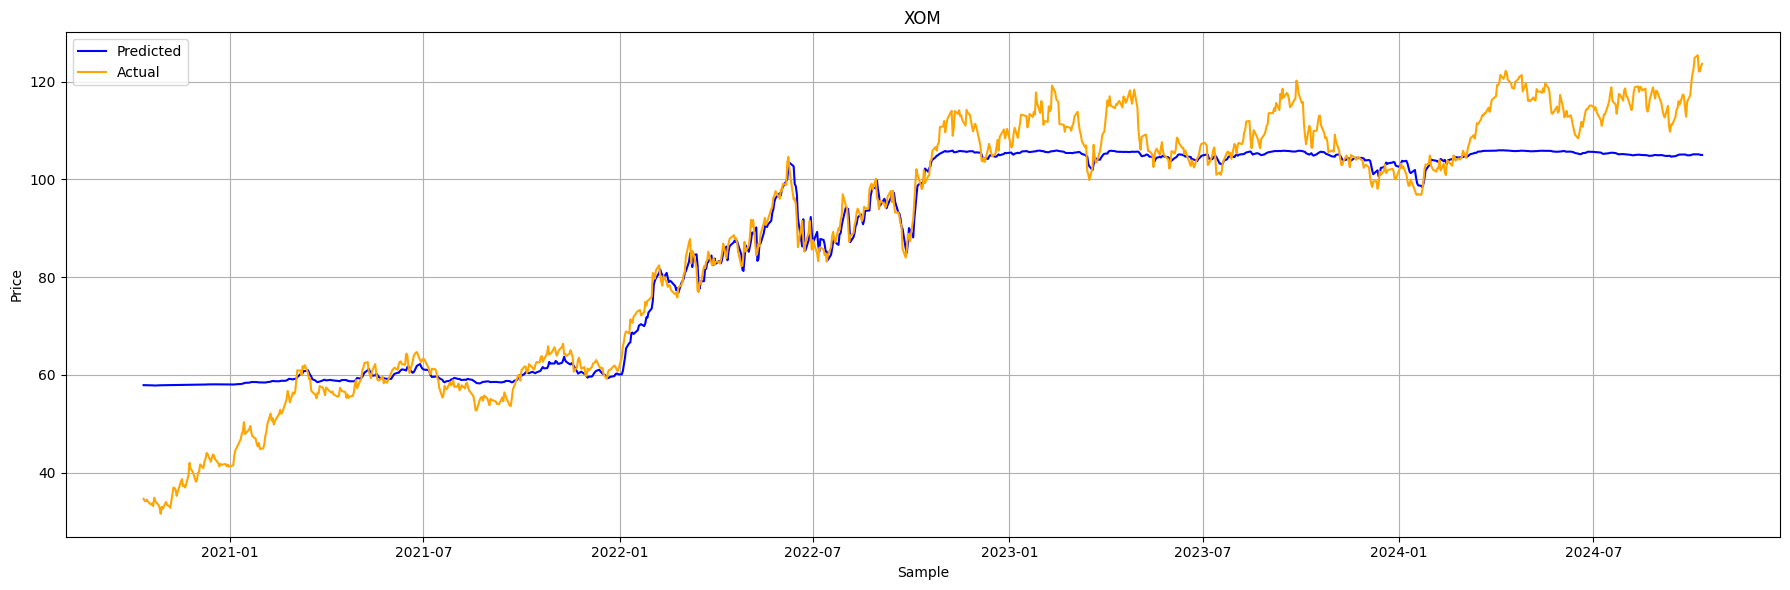

MAE: 5.252211064449488
Naive MAE: 28.570124352965188
MASE: 0.18383577892633082
Predictions saved to: /home/ubuntu/dse4212/dse4212_lstm/predictions_XOM_20241027_082213.csv
[CV] END batch_size=32, epochs=150, model__dense_activation=softplus, model__layer_1_units=100, model__layer_2_units=50, model__loss=mean_absolute_error, model__optimizer=adam; total time= 1.9min


/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.lo

[CV] END batch_size=32, epochs=150, model__dense_activation=softplus, model__layer_1_units=100, model__layer_2_units=50, model__loss=mean_absolute_error, model__optimizer=adam; total time= 2.4min


/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.local/lib/python3.8/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/ubuntu/.lo

In [19]:
for i in range(len(target_stocks)):
    # Step 1: Generate dataset
    target_stock = [target_stocks[i]]
    combined_X, combined_y = prepare_wide_format(
        combined_df, target_stock, feature_stocks, selected_columns, lag=lag[i]
    )

    print("Shape of X (features):", combined_X.shape)
    print("Shape of y (target):", combined_y.shape)

    # Split the data
    split_date = pd.to_datetime('2020-10-12').date()
    train_X = combined_X[combined_X.index < split_date]
    test_X = combined_X[combined_X.index >= split_date]
    train_y = combined_y[combined_y.index < split_date]
    test_y = combined_y[combined_y.index >= split_date]

    # Sort columns by extracted lag numbers, keeping non-lag columns in place
    sorted_cols = sorted(train_X.columns, key=extract_lag_number, reverse=True)
    train_X = train_X[sorted_cols]
    test_X = test_X[sorted_cols]

    # Step 2: Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(train_X)

    y_scaler = StandardScaler()
    y_scaled = y_scaler.fit_transform(train_y)

    # Step 3: Reshape the input for LSTM
    n_features = train_X.shape[1] // lag[i]
    X_reshaped = X_scaled.reshape((X_scaled.shape[0], lag[i], n_features))

    # Step 4: Wrap model for GridSearchCV
    model = KerasRegressor(
        build_fn=create_lstm_model,
        input_shape=(lag[i], n_features),
        verbose=2
    )

    # Apply GridSearchCV
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    grid = GridSearchCV(
        estimator=model, param_grid=param_grid,
        cv=3, verbose=2, n_jobs=2
    )

    grid_result = grid.fit(X_reshaped, y_scaled, callbacks=[early_stopping], validation_split=0.2)
    best_model = grid_result.best_estimator_

    # Step 6: Save the model weights
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # e.g., 20241022_154530
    model_name = f"{target_stocks[i].replace(':', '_')}_best_model_{timestamp}.h5"
    model_path = os.path.join(save_dir, model_name)
    joblib.dump(best_model, model_path) # Save model
    print(f"Model weights saved to: {model_path}")

    print(f"Best params for {target_stock}: {grid_result.best_params_}")

    # Step 8: Predict using the best model
    y_pred = predict_stock_prices(test_X, scaler, y_scaler, lag[i], best_model)

    # Step 9: Plot
    y_test, y_pred = plot_predictions_vs_actuals(y_pred, test_y, target_stocks)
    
    # Step 10: Get naive predictions
    y_naive = get_naive_prediction(combined_y, test_y, lag=1)

    # Step 10: Output predictions and save to CSV
    # Create a DataFrame for predictions including naive predictions and actual values
    predictions_df = pd.DataFrame({
        'Date': test_y.index,                      # Dates
        'Naive Prediction': y_naive.flatten(),     # Naive predictions
        'Predicted': y_pred.flatten(),             # Model predictions
        'Actual': test_y.values.flatten()          # Actual values
    })

    # Step 11: Save predictions to CSV
    predictions_file = os.path.join(save_dir, f"predictions_{target_stocks[i].replace(':', '_')}_{timestamp}.csv")
    predictions_df.to_csv(predictions_file, index=False)
    print(f"Predictions saved to: {predictions_file}")

## Step 8: Making predictions from the trained model

/tmp/ipykernel_2143/612497795.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date']).dt.date


Shape of X (features): (3643, 100)
Shape of y (target): (3643, 1)


2024-10-26 08:59:54.742114: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0c89d2b80378435ebf1f664588171b19: INVALID_ARGUMENT: ram://0c89d2b80378435ebf1f664588171b19 is a directory.


Loaded model from: /home/ubuntu/dse4212/dse4212_lstm/EQNR_best_model_20241026_084742.h5
32/32 - 0s - 192ms/epoch - 6ms/step


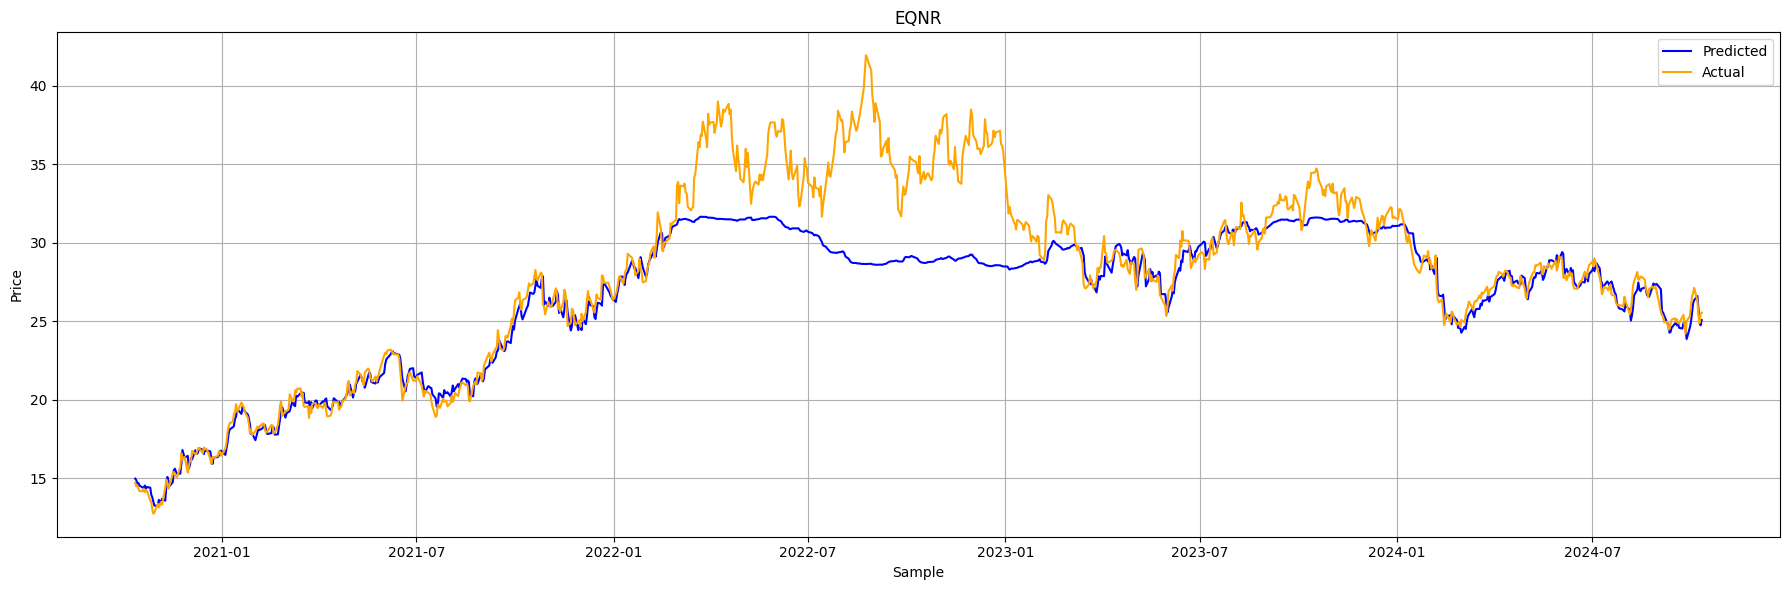

MAE: 1.7227472643961144
Naive MAE: 6.922805860466308
MASE: 0.24885101490915898
Predictions saved to: /home/ubuntu/dse4212/dse4212_lstm/predictions_EQNR_20241026_084742.csv


In [33]:
param_grid = {
    'model__layer_1_units': [250, 100],       # Number of units in the LSTM layer
    'model__layer_2_units': [100, 50],
    'model__optimizer': ['adam'], # Optimizers to try
    'model__loss': ['mean_squared_error', 'mean_absolute_error'],
    'model__dense_activation': [None, 'tanh', 'sigmoid', 'softplus'],
    'batch_size': [32],           # Batch sizes
    'epochs': [100, 150]               # Number of epochs
}

target_stocks = ['BP', 'CVX', 'EQNR', 'OXY', 'SHEL','XOM']  # 6 stocks that we are predicting
feature_stocks = ['NYMEX:CL1!', 'NYMEX:NG1!']  # Additional stocks as features

# Specify filename of model
# TODO: Change model name accordingly
model_name = f"EQNR_best_model_20241026_084742.h5"
model_name = f"../../data/results/lstm/{model_name}"

selected_columns = ["date", "symbol", "close"]
lag = [100, 100, 100, 100, 100, 100]

for i in range(len(target_stocks)):
    # Step 1: Generate dataset
    target_stock = [target_stocks[i]]
    combined_X, combined_y = prepare_wide_format(
        combined_df, target_stock, feature_stocks, selected_columns, lag=lag[i]
    )

    print("Shape of X (features):", combined_X.shape)
    print("Shape of y (target):", combined_y.shape)

    # Split the data
    split_date = pd.to_datetime('2020-10-12').date()
    train_X = combined_X[combined_X.index < split_date]
    test_X = combined_X[combined_X.index >= split_date]
    train_y = combined_y[combined_y.index < split_date]
    test_y = combined_y[combined_y.index >= split_date]

    # Sort columns by extracted lag numbers, keeping non-lag columns in place
    sorted_cols = sorted(train_X.columns, key=extract_lag_number, reverse=True)
    train_X = train_X[sorted_cols]
    test_X = test_X[sorted_cols]

    # Step 2: Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(train_X)

    y_scaler = StandardScaler()
    y_scaled = y_scaler.fit_transform(train_y)

    # Step 3: Reshape the input for LSTM
    n_features = train_X.shape[1] // lag[i]
    X_reshaped = X_scaled.reshape((X_scaled.shape[0], lag[i], n_features))

    model_path = os.path.join(save_dir, model_name)
    loaded_model = joblib.load(model_path)  # Load model with joblib

    print(f"Loaded model from: {model_path}")

    # Step 8: Predict using the best model
    y_pred = predict_stock_prices(test_X, scaler, y_scaler, lag[i], best_model)

    # Step 9: Plot
    y_test, y_pred = plot_predictions_vs_actuals(y_pred, test_y, target_stocks)

    # Step 10: Calculate MASE
    y_naive = get_naive_prediction(combined_y, test_y)

    # Step 11: Output predictions and save to CSV
    # Create a DataFrame for predictions including naive predictions and actual values
    predictions_df = pd.DataFrame({
        'Date': test_y.index,                      # Dates
        'Naive Prediction': y_naive.flatten(),     # Naive predictions
        'Predicted': y_pred.flatten(),             # Model predictions
        'Actual': test_y.values.flatten()          # Actual values
    })

    # Save predictions to CSV
    predictions_file = os.path.join(save_dir, f"predictions_{target_stocks[i].replace(':', '_')}_{timestamp}.csv")
    predictions_df.to_csv(predictions_file, index=False)
    print(f"Predictions saved to: {predictions_file}")